# <b>월간 데이콘 3 게임 행동 데이터 분석

##### 작성자 : 허은정
##### 마지막 수정 : 20.03.21 08:00

event=Selection인 경우 event_contents 더미 변수 생성

In [0]:
# 비활성화방지, F12 개발자도구. 콘솔창에 입력

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

### <b>라이브러리 및 데이터

#### 구글 드라이브에 마운트

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### 라이브러리 설치

In [2]:
import os                                            # 디렉토리 설정
os.chdir("/content/gdrive/My Drive/game")
import warnings                                      # 경고 메세지 무시
warnings.filterwarnings('ignore')
import pandas as pd                                  # 데이터 조작, 분석
import numpy as np                                   # 행렬 연산
import random                                        # 난수 생성
random.seed(2020)
import time                                          # 시간 측정

from sklearn.model_selection import train_test_split # train, validation 데이터 나누기
from sklearn import metrics                          # AUC 측정
!pip install catboost
from catboost import CatBoostClassifier, Pool        # CatBoost 모델링
from lightgbm.sklearn import LGBMClassifier          # lightGBM 모델링

import matplotlib.pyplot as plt                      # 시각화

     |████████████████████████████████| 64.4MB 48kB/s 


#### 데이터 불러오기

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### <b>EDA

time
- 2.24는 2분24초, 10진법 아님, 분에 60 곱해서 초단위로 바꾸기
- min: 0.08, max: 10.59, 빨리끝나는건 어떻게할지 생각, 시간 말고 행동 총 개수로 구간 나누어서 변수 추가해도 될듯

event | event_contents(여러개 ;으로 구분)

1. Ability : 생산, 공격 등 선수의 주요 행동 | (3~4자리 16진수) - string; Location: (x좌표, y좌표, int); 더 봐야함
2. AddToControlGroup : 부대에 추가 | None밖에 없음
3. Camera : 시점 선택 | at (x좌표,y좌표)
4. ControlGroup : 부대 행동 | None밖에 없음
5. GetControlGroup : 부대 불러오기 | None밖에 없음
6. Right Click : 마우스 우클릭 |  Location: (x좌표, y좌표, int); Target: String [int+string]; 더 봐야함
7. Selection : 객체 선택 | ['string [int+string]']
8. SetControlGroup : 부대 지정


액션의 다양성, 유니크함, 행동 지연 시간, PAC 카메라 당 행동 지속 시간 만들어보기, 3분이내 총 이벤트 수

In [15]:
X['time'] = train.drop_duplicates(['game_id'],keep='last').time.reset_index(drop=True)
X['time'] = (X.time*100//100*60 + X.time*100%100).astype(int)
X

,time
0,444
1,599
2,599
3,599
4,343
...,...
38867,502
38868,599
38869,505
38870,356


In [19]:
  species = train[train.player == p].drop_duplicates(['game_id']).species.reset_index(drop=True)
  X = pd.concat([X, pd.get_dummies(species)], axis=1)
  X.rename(columns = {'P':'protoss_'+pp, 'T':'terran_'+pp, 'Z':'zerg_'+pp}, inplace = True)
  X

,time,protoss_0,terran_0,zerg_0,protoss_0,terran_0,zerg_0
0,444,0,1,0,0,1,0
1,599,1,0,0,1,0,0
2,599,1,0,0,1,0,0
3,599,0,1,0,0,1,0
4,343,0,1,0,0,1,0
...,...,...,...,...,...,...,...
38867,502,0,1,0,0,1,0
38868,599,0,1,0,0,1,0
38869,505,1,0,0,1,0,0
38870,356,1,0,0,1,0,0


In [0]:
# game_id 개수만큼의 index를 가진 DataFrame X 생성
n = train.game_id.max()+1
X = pd.DataFrame(index=range(n))

# time 변수
X['time'] = train.drop_duplicates(['game_id'],keep='last').time.reset_index(drop=True)
X['time'] = (X.time*100//100*60 + X.time*100%100).astype(int)

for p in [0,1]:
  pp = str(p)

  # species 더미 변수
  species = train[train.player == p].drop_duplicates(['game_id']).species.reset_index(drop=True)
  X = pd.concat([X, pd.get_dummies(species)], axis=1)
  X.rename(columns = {'P':'protoss_'+pp, 'T':'terran_'+pp, 'Z':'zerg_'+pp}, inplace = True)

  # event 카운트
  X['event_'+pp] = train[train.player == p].iloc[:,0:2].groupby('game_id').count()
  print('event_'+pp)
  print(time.time()-current)

  # event 카운트한 것 / time
  X['event_per_sec_'+pp] = X['event_'+pp] / X.time

  # event == Ability, AddToControlGroup, Camera, ControlGroup, GetControlGroup, Right Click, Selection, SetControlGroup일 때 각각 카운트
  event = train.event.unique()
  for i in event:
    X[i+'_'+pp] = train[(train.player == p) & (train.event == i)].iloc[:,0:2].groupby('game_id').count()
  X.loc[:,[i+'_'+pp for i in event]] = X.loc[:,[i+'_'+pp for i in event]].fillna(0).astype(int)

  # event == Camera일 때 event_contents의 2차원 좌표 간 euclidean distance 합
  def move_sum(i):
    return sum(np.sqrt(np.diff(i.map(lambda x: x[4:x.find(',')]).astype(float)) **2 + 
                       np.diff(i.map(lambda x: x[x.find(',')+2:len(x)-1]).astype(float)) **2))
  X['move_sum_'+pp] = train[(train.player == p) & (train.event == 'Camera')].iloc[:,[0,6]].groupby('game_id').agg(move_sum)
  X['move_sum_'+pp] = X['move_sum_'+pp].fillna(0)

  # event == Ability일 때 event_contents 더미 변수 생성, 카운트
  contents = pd.get_dummies(train.event_contents[(train.event == 'Ability')].map(lambda x: x[x.find('(')+1:x.find(')')]))  # event_contents의 16진수 코드만 추출, 더미 변수 생성
  contents_only_train = set(contents.keys()) - set(test.event_contents[(test.event == 'Ability')].map(lambda x: x[x.find('(')+1:x.find(')')])) # train에만 있고 test에는 없는 것
  contents = contents.drop(contents_only_train, axis=1)                                                                              # only_train 삭제, 362개의 더미 변수만 남음
  contents['game_id'], contents['player'] = train.game_id, train.player
  contents_X = contents.iloc[:,[x for x in range(180)]+[362]][contents.player == p].groupby('game_id').sum() # X의 column 형태로 만들기, RAM 에러나서 180, 182개로 나누어 처리
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  contents_X = contents.iloc[:,[x+180 for x in range(182)]+[362]][contents.player == p].groupby('game_id').sum()
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  X.iloc[:,-362:] = X.iloc[:,-362:].fillna(0).astype(int)

  # event == Ability일 때 사용한 event_content 종류 카운트
  X['Ability_variety_'+pp] = (X.iloc[:,-362:]/X.iloc[:,-362:]).fillna(0).astype(int).sum(axis=1)

  # event == Ability일 때 사용한 event_content 최빈값 / Ability
  X['Ability_mode_'+pp] =  X.iloc[:,-363:-1].max(axis=1) / X['Ability_'+pp]
  
  # event == Selection일 때 event_contents 더미 변수 생성, 카운트
  contents = pd.get_dummies(train.event_contents[(train.event == 'Selection')].map(lambda x: x[x.find('\'')+1:x.find(' ')]))  # 더미 변수 생성
  contents_only_train = set(contents.keys()) - set(test.event_contents[(test.event == 'Selection')].map(lambda x: x[x.find('\'')+1:x.find(' ')])) # train에만 있고 test에는 없는 것
  contents = contents.drop(contents_only_train, axis=1) 
  contents['game_id'], contents['player'] = train.game_id, train.player
  contents_X = contents.iloc[:,:172][contents.player == p].groupby('game_id').sum() # X의 column 형태로 만들기
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  X.iloc[:,-171:] = X.iloc[:,-171:].fillna(0).astype(int)

  # event == Selection일 때 사용한 event_content 종류 카운트
  X['Selection_variety_'+pp] = (X.iloc[:,-171:]/X.iloc[:,-171:]).fillna(0).astype(int).sum(axis=1)

  # event == Selection일 때 사용한 event_content 최빈값 / Selection
  X['Selection_mode_'+pp] =  X.iloc[:,-172:-1].max(axis=1) / X['Selection_'+pp]

# player 0,1 자리 바꾼 X1생성, X와 행 병합해 데이터 2배로 만들기
c = X.shape[1]//2+1
X1 = X.copy()
X1.columns = ['time']+list(X.columns[c:])+list(X.columns[1:c])
X1.index = [x+n for x in range(n)]
X = pd.concat([X, X1])

### <b>데이터 전처리

X (만들어본 피쳐 모두 포함)

In [0]:
# game_id 개수만큼의 index를 가진 DataFrame X 생성
n = train.game_id.max()+1
X = pd.DataFrame(index=range(n))

current = time.time()

# time 변수
X['time'] = train.drop_duplicates(['game_id'],keep='last').time.reset_index(drop=True)
X['time'] = (X.time*100//100*60 + X.time*100%100).astype(int)
print('time')
print(time.time()-current)

for p in [0,1]:
  pp = str(p)

  # species 더미 변수
  species = train[train.player == p].drop_duplicates(['game_id']).species.reset_index(drop=True)
  X = pd.concat([X, pd.get_dummies(species)], axis=1)
  X.rename(columns = {'P':'protoss_'+pp, 'T':'terran_'+pp, 'Z':'zerg_'+pp}, inplace = True)
  print('species_'+pp)
  print(time.time()-current)

  # event 카운트
  X['event_'+pp] = train[train.player == p].iloc[:,0:2].groupby('game_id').count()
  print('event_'+pp)
  print(time.time()-current)

  # 3분 이내 event 카운트
  for x in range(3):
    X[str(x)+'min_event_'+pp] = train[(train.player == p) & (train.time > x) & (train.time < x+1)].iloc[:,0:2].groupby('game_id').count()
  print('event_3min_'+pp)
  print(time.time()-current)

  # event 카운트한 것 / time
  X['event_per_sec_'+pp] = X['event_'+pp] / X.time
  print('event_per_time_'+pp)
  print(time.time()-current)

  # event == Ability, AddToControlGroup, Camera, ControlGroup, GetControlGroup, Right Click, Selection, SetControlGroup일 때 각각 카운트
  event = train.event.unique()
  for i in event:
    X[i+'_'+pp] = train[(train.player == p) & (train.event == i)].iloc[:,0:2].groupby('game_id').count()
  X.loc[:,[i+'_'+pp for i in event]] = X.loc[:,[i+'_'+pp for i in event]].fillna(0).astype(int)
  print('event_value_'+pp)
  print(time.time()-current)

  # 3분 이내 event 값 각각 카운트
  for x in range(3):
    for i in event:
      X[str(x)+'min_'+i+'_'+pp] = train[(train.player == p) & (train.time > x) & (train.time < x+1) & (train.event == i)].iloc[:,0:2].groupby('game_id').count()
    X.loc[:,[str(x)+'min_'+i+'_'+pp for i in event]] = X.loc[:,[str(x)+'min_'+i+'_'+pp for i in event]].fillna(0).astype(int)
  print('event_value_3min_'+pp)
  print(time.time()-current)

  # event 값 각각 카운트한 것 / time
  for i in range(8):
    X[event[i]+'_per_sec_'+pp] = X[event[i]+'_'+pp] / X.time
  print('event_value_per_time_'+pp)
  print(time.time()-current)

  # event 값 각각 카운트한 것 / event
  for i in range(8):
    X[event[i]+'_div_event_'+pp] = X[event[i]+'_'+pp] / X['event_'+pp]
  print('event_value_div_event_'+pp)
  print(time.time()-current)

  # Camera / Ability
  X['Camera_div_ability'+pp] = X['Camera_'+pp] / X['Ability_'+pp]

  # Camera / Right Click
  X['Camera__div_rightclick'+pp] = X['Camera_'+pp] / X['Right Click_'+pp]

  # Camera / Selection
  X['Camera__div_selection'+pp] = X['Camera_'+pp] / X['Selection_'+pp]
  print('camera_div_'+pp)
  print(time.time()-current)

  # event == Camera일 때 event_contents의 2차원 좌표 간 euclidean distance 합
  def move_sum(i):
    return sum(np.sqrt(np.diff(i.map(lambda x: x[4:x.find(',')]).astype(float)) **2 + 
                       np.diff(i.map(lambda x: x[x.find(',')+2:len(x)-1]).astype(float)) **2))
  X['move_sum_'+pp] = train[(train.player == p) & (train.event == 'Camera')].iloc[:,[0,6]].groupby('game_id').agg(move_sum)
  X['move_sum_'+pp] = X['move_sum_'+pp].fillna(0)
  print('move_sum_'+pp)
  print(time.time()-current)

  # move_sum / time
  X['move_sum_per_sec_'+pp] = X['move_sum_'+pp] / X.time
  print('move_sum_per_time_'+pp)
  print(time.time()-current)

  # move_sum / event
  X['move_sum_div_event_'+pp] = X['move_sum_'+pp] / X['event_'+pp]
  print('move_sum_div_event_'+pp)
  print(time.time()-current)

  # event == Ability일 때 event_contents 더미 변수 생성, 카운트
  contents = pd.get_dummies(train.event_contents[(train.event == 'Ability')].map(lambda x: x[x.find('(')+1:x.find(')')]))  # event_contents의 16진수 코드만 추출, 더미 변수 생성
  contents_only_train = set(contents.keys()) - set(test.event_contents[(test.event == 'Ability')].map(lambda x: x[x.find('(')+1:x.find(')')])) # train에만 있고 test에는 없는 것
  contents = contents.drop(contents_only_train, axis=1)                                                                              # only_train 삭제, 362개의 더미 변수만 남음
  contents['game_id'], contents['player'] = train.game_id, train.player
  contents_X = contents.iloc[:,[x for x in range(180)]+[362]][contents.player == p].groupby('game_id').sum() # X의 column 형태로 만들기, RAM 에러나서 180, 182개로 나누어 처리
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  contents_X = contents.iloc[:,[x+180 for x in range(182)]+[362]][contents.player == p].groupby('game_id').sum()
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  X.iloc[:,-362:] = X.iloc[:,-362:].fillna(0).astype(int)
  print('ability_'+pp)
  print(time.time()-current)

  # event == Ability일 때 사용한 event_content 종류 카운트
  X['Ability_variety_'+pp] = (X.iloc[:,-362:]/X.iloc[:,-362:]).fillna(0).astype(int).sum(axis=1)

  # event == Ability일 때 사용한 event_content 최빈값 / Ability
  X['Ability_mode_'+pp] =  X.iloc[:,-363:-1].max(axis=1) / X['Ability_'+pp]
  print('ability_value_'+pp)
  print(time.time()-current)

  # event == Ability일 때 event_contents 각각 카운트 한 것 / time
  for i in contents.keys()[:362]:
    X[i+'_per_sec_'+pp] = X[i+'_'+pp] / X['time']
  print('ability_per_sec_'+pp)
  print(time.time()-current)

  # event == Ability일 때 event_contents 각각 카운트 한 것 / event
  for i in contents.keys()[:362]:
    X[i+'_div_event_'+pp] = X[i+'_'+pp] / X['event_'+pp]
  print('ability_div_event_'+pp)
  print(time.time()-current)

  # event == Selection일 때 event_contents 더미 변수 생성, 카운트
  contents = pd.get_dummies(train.event_contents[(train.event == 'Selection')].map(lambda x: x[x.find('\'')+1:x.find(' ')]))  # 더미 변수 생성
  contents_only_train = set(contents.keys()) - set(test.event_contents[(test.event == 'Selection')].map(lambda x: x[x.find('\'')+1:x.find(' ')])) # train에만 있고 test에는 없는 것
  contents = contents.drop(contents_only_train, axis=1) 
  contents['game_id'], contents['player'] = train.game_id, train.player
  contents_X = contents.iloc[:,[x for x in range(90)]+[171]][contents.player == p].groupby('game_id').sum() # X의 column 형태로 만들기, RAM 에러나서 90, 81개로 나누어 처리
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  contents_X = contents.iloc[:,[x+90 for x in range(81)]+[171]][contents.player == p].groupby('game_id').sum()
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  X.iloc[:,-171:] = X.iloc[:,-171:].fillna(0).astype(int)
  print('selection_'+pp)
  print(time.time()-current)

  # event == Selection일 때 사용한 event_content 종류 카운트
  X['Selection_variety_'+pp] = (X.iloc[:,-171:]/X.iloc[:,-171:]).fillna(0).astype(int).sum(axis=1)

  # event == Selection일 때 사용한 event_content 최빈값 / Selection
  X['Selection_mode_'+pp] =  X.iloc[:,-172:-1].max(axis=1) / X['Selection_'+pp]
  print('selection_value_'+pp)
  print(time.time()-current)

  # event == Selection일 때 event_contents 각각 카운트 한 것 / time
  for i in contents.keys()[:171]:
    X[i+'_per_sec_'+pp] = X[i+'_'+pp] / X['time']
  print('selection_per_sec_'+pp)
  print(time.time()-current)

  # event == Selection일 때 event_contents 각각 카운트 한 것 / event
  for i in contents.keys()[:171]:
    X[i+'_div_event_'+pp] = X[i+'_'+pp] / X['event_'+pp]
  print('selection_div_event_'+pp)
  print(time.time()-current)


# player 0,1 자리 바꾼 X1생성, X와 행 병합해 데이터 2배로 만들기
c = X.shape[1]//2+1
X1 = X.copy()
X1.columns = ['time']+list(X.columns[c:])+list(X.columns[1:c])
X1.index = [x+n for x in range(n)]
X = pd.concat([X, X1])
print('concatX1')
print(time.time()-current)

time
1.1798274517059326
species_0
5.884106397628784
event_0
9.653936386108398
event_3min_0
12.684998989105225
event_per_time_0
12.687364101409912
event_value_0
48.040037631988525
event_value_3min_0
140.63973307609558
event_value_per_time_0
140.65210103988647
event_value_div_event_0
140.66352605819702
camera_div_0
140.66802620887756
move_sum_0
221.96112084388733
move_sum_per_time_0
221.96351861953735
move_sum_div_event_0
221.96535658836365
ability_0
263.7130868434906
ability_value_0
264.44639444351196
ability_per_sec_0
265.13973665237427
ability_div_event_0
266.1652572154999
selection_0
319.87895107269287
selection_value_0
320.3669490814209
selection_per_sec_0
320.7837071418762
selection_div_event_0
321.410213470459
species_1
326.13013911247253
event_1
330.1194291114807
event_3min_1
333.2043123245239
event_per_time_1
333.2064423561096
event_value_1
369.38701462745667
event_value_3min_1
464.5905337333679
event_value_per_time_1
464.603657245636
event_value_div_event_1
464.6173071861267
ca

X (실제로 모델에 적용시킬 것)

In [0]:
# game_id 개수만큼의 index를 가진 DataFrame X 생성
n = train.game_id.max()+1
X = pd.DataFrame(index=range(n))

current = time.time()

# time 변수
X['time'] = train.drop_duplicates(['game_id'],keep='last').time.reset_index(drop=True)
X['time'] = (X.time*100//100*60 + X.time*100%100).astype(int)
print('time')
print(time.time()-current)

for p in [0,1]:
  pp = str(p)

  # species 더미 변수
  species = train[train.player == p].drop_duplicates(['game_id']).species.reset_index(drop=True)
  X = pd.concat([X, pd.get_dummies(species)], axis=1)
  X.rename(columns = {'P':'protoss_'+pp, 'T':'terran_'+pp, 'Z':'zerg_'+pp}, inplace = True)
  print('species_'+pp)
  print(time.time()-current)

  # event 카운트
  X['event_'+pp] = train[train.player == p].iloc[:,0:2].groupby('game_id').count()
  print('event_'+pp)
  print(time.time()-current)

  # event == Ability, AddToControlGroup, Camera, ControlGroup, GetControlGroup, Right Click, Selection, SetControlGroup일 때 각각 카운트
  event = train.event.unique()
  for i in event:
    X[i+'_'+pp] = train[(train.player == p) & (train.event == i)].iloc[:,0:2].groupby('game_id').count()
  X.loc[:,[i+'_'+pp for i in event]] = X.loc[:,[i+'_'+pp for i in event]].fillna(0).astype(int)
  print('event_value_'+pp)
  print(time.time()-current)

  # 1분 이내 event 값 각각 카운트
  for i in event:
    X['1min_'+i+'_'+pp] = train[(train.player == p) & (train.time >= 0) & (train.time < 1) & (train.event == i)].iloc[:,0:2].groupby('game_id').count()
  X.loc[:,['1min_'+i+'_'+pp for i in event]] = X.loc[:,['1min_'+i+'_'+pp for i in event]].fillna(0).astype(int)
  print('event_value_1min_'+pp)
  print(time.time()-current)

  # event == Camera일 때 event_contents의 2차원 좌표 간 euclidean distance 합
  def move_sum(i):
    return sum(np.sqrt(np.diff(i.map(lambda x: x[4:x.find(',')]).astype(float)) **2 + 
                       np.diff(i.map(lambda x: x[x.find(',')+2:len(x)-1]).astype(float)) **2))
  X['move_sum_'+pp] = train[(train.player == p) & (train.event == 'Camera')].iloc[:,[0,6]].groupby('game_id').agg(move_sum)
  X['move_sum_'+pp] = X['move_sum_'+pp].fillna(0)
  print('move_sum_'+pp)
  print(time.time()-current)

  # event == Ability일 때 event_contents 더미 변수 생성, 카운트
  contents = pd.get_dummies(train.event_contents[(train.event == 'Ability')].map(lambda x: x[x.find('(')+1:x.find(')')]))  # event_contents의 16진수 코드만 추출, 더미 변수 생성
  contents_only_train = set(contents.keys()) - set(test.event_contents[(test.event == 'Ability')].map(lambda x: x[x.find('(')+1:x.find(')')])) # train에만 있고 test에는 없는 것
  contents = contents.drop(contents_only_train, axis=1)                                                                              # only_train 삭제, 362개의 더미 변수만 남음
  contents['game_id'], contents['player'] = train.game_id, train.player
  contents_X = contents.iloc[:,[x for x in range(180)]+[362]][contents.player == p].groupby('game_id').sum() # X의 column 형태로 만들기, RAM 에러나서 180, 182개로 나누어 처리
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  contents_X = contents.iloc[:,[x+180 for x in range(182)]+[362]][contents.player == p].groupby('game_id').sum()
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  X.iloc[:,-362:] = X.iloc[:,-362:].fillna(0).astype(int)
  print('ability_'+pp)
  print(time.time()-current)

  # event == Selection일 때 event_contents 더미 변수 생성, 카운트
  contents = pd.get_dummies(train.event_contents[(train.event == 'Selection')].map(lambda x: x[x.find('\'')+1:x.find(' ')]))  # 더미 변수 생성
  contents_only_train = set(contents.keys()) - set(test.event_contents[(test.event == 'Selection')].map(lambda x: x[x.find('\'')+1:x.find(' ')])) # train에만 있고 test에는 없는 것
  contents = contents.drop(contents_only_train, axis=1) 
  contents['game_id'], contents['player'] = train.game_id, train.player
  contents_X = contents.iloc[:,[x for x in range(90)]+[171]][contents.player == p].groupby('game_id').sum() # X의 column 형태로 만들기, RAM 에러나서 90, 81개로 나누어 처리
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  contents_X = contents.iloc[:,[x+90 for x in range(81)]+[171]][contents.player == p].groupby('game_id').sum()
  for i in contents_X.keys():
    X[i+'_'+pp] = contents_X[i]
  X.iloc[:,-171:] = X.iloc[:,-171:].fillna(0).astype(int)
  print('selection_'+pp)
  print(time.time()-current)

# player 0,1 자리 바꾼 X1생성, X와 행 병합해 데이터 2배로 만들기
c = X.shape[1]//2+1
X1 = X.copy()
X1.columns = ['time']+list(X.columns[c:])+list(X.columns[1:c])
X1.index = [x+n for x in range(n)]
X = pd.concat([X, X1])
print('concatX1')
print(time.time()-current)

time
1.2022383213043213
species_0
5.1716039180755615
event_0
9.384057521820068
event_value_0
45.1543390750885
event_value_1min_0
75.8543713092804
move_sum_0
156.30931949615479
ability_0
191.5959393978119
selection_0
238.33586883544922
species_1
243.79245471954346
event_1
248.00248885154724
event_value_1
283.7615828514099
event_value_1min_1
314.668438911438
move_sum_1
395.84509921073914
ability_1
431.577264547348
selection_1
474.4099440574646
concatX1
475.36510610580444


y

In [0]:
y = train.drop_duplicates(['game_id', 'winner']).winner.reset_index(drop=True)
y = y.append(-(y - 1)).reset_index(drop=True)

test_X (train 데이터 X에 맞게 수정 필요)

In [0]:
nn = test.game_id.max()-test.game_id.min()+1
test_X = pd.DataFrame(index=[x+n for x in range(nn)])

test_X['time'] = test.drop_duplicates(['game_id'],keep='last').set_index('game_id').time
test_X['time'] = (test_X.time *100 //100 *60 + test_X.time *100 %100).astype(int)

for p in [0,1]:
  pp = str(p)

  # species 더미 변수
  species = test[test.player == p].drop_duplicates(['game_id']).species.reset_index(drop=True)
  test_X = pd.concat([test_X, pd.get_dummies(species)], axis=1)
  test_X.rename(columns = {'P':'protoss_'+pp, 'T':'terran_'+pp, 'Z':'zerg_'+pp}, inplace = True)

  # event 카운트
  test_X['event_'+pp] = test[test.player == p].iloc[:,0:2].groupby('game_id').count()

  # event 카운트한 것 / time
  test_X['event_per_sec'+pp] = test_X['event_'+pp] / test_X.time

  # event == Ability일 때 AddToControlGroup, Camera, ControlGroup, GetControlGroup, Right Click, Selection, SetControlGroup 각각 카운트
  event = test.event.unique()
  for i in range(len(event)):
    test_X[event[i]+'_'+pp] = test[(test.player == p) & (test.event == event[i])].iloc[:,0:2].groupby('game_id').count()
  test_X.loc[:,[x+'_'+pp for x in event]] = test_X.loc[:,[x+'_'+pp for x in event]].fillna(0).astype(int)

  # event 각각 카운트한 것 / time
  for i in range(8):
    test_X[event[i]+'_per_sec_'+pp] = X[event[i]+'_'+pp] / test_X.time

  # 카메라 이동거리, event == Camera일 때 event_contents의 2차원 좌표 간 euclidean distance 합
  def move_sum(i):
    return sum(np.sqrt(np.diff(i.map(lambda x: x[4:x.find(',')]).astype(float)) **2 + 
                       np.diff(i.map(lambda x: x[x.find(',')+2:len(x)-1]).astype(float)) **2))
  test_X['move_sum_'+pp] = test[(test.player == p) & (test.event == 'Camera')].iloc[:,[0,6]].groupby('game_id').agg(move_sum)
  test_X['move_sum_'+pp] = test_X['move_sum_'+pp].fillna(0)

  # event == Ability일 때 event_contents 더미 변수 생성, 카운트
  contents = pd.get_dummies(test.event_contents[(test.event == 'Ability')].map(lambda x: x[x.find('(')+1:x.find(')')]))     # event_contents의 16진수 코드만 추출, 더미 변수 생성
  contents_only_test = set(contents.keys()) - set(train.event_contents[(train.event == 'Ability')].map(lambda x: x[x.find('(')+1:x.find(')')])) # test에만 있고 train에는 없는 것
  contents = contents.drop(contents_only_test, axis=1)                                                                                 # only_test 삭제, 362개의 더미 변수만 남음
  contents['game_id'], contents['player'] = test.game_id, test.player
  contents_X = contents.iloc[:,[x for x in range(180)]+[362]][contents.player == p].groupby('game_id').sum() # X의 column 형태로 만들기, RAM 에러나서 180, 182개로 나누어 처리
  for i in contents_X.keys():
    test_X[i+'_'+pp] = contents_X[i]
  contents_X = contents.iloc[:,[x+180 for x in range(182)]+[362]][contents.player == p].groupby('game_id').sum()
  for i in contents_X.keys():
    test_X[i+'_'+pp] = contents_X[i]
  test_X.iloc[:,-362:] = test_X.iloc[:,-362:].fillna(0).astype(int)

  for i in contents.keys()[:362]:
    test_X['per_sec_'+i+'_'+pp] = test_X[i+'_'+pp] / test_X.time

### <b>모델 생성

catboost

In [0]:
random_seed = 2020

In [0]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.33, random_state=random_seed)

In [0]:
model = CatBoostClassifier(iterations=25000,              # 반복횟수 최대 25000
                           learning_rate=0.001,           # 러닝레이트 0.001
                           depth=10,                       # 트리 깊이 ~16, 디폴트 6
                           l2_leaf_reg=30,                # L2 정규화
                           random_seed=random_seed,       # 랜덤시드 고정
                           eval_metric='AUC',             # AUC로 성능 측정
                           metric_period=2500,            # 중간결과 출력
                           early_stopping_rounds=1000,    # 1000iteration 동안 AUC 증가 없으면 학습 중단
                           grow_policy='Lossguide',   # 트리 생성 방식, SymmetricTree는 wide, 깊이 일정, Lossguide는 deep
                           task_type='GPU'                # GPU 사용
                           )
model.fit(train_X, train_y, eval_set=(valid_X, valid_y))
#test_pred = model.predict_proba(test_X)

0:	learn: 0.6467034	test: 0.6387588	best: 0.6387588 (0)	total: 31.1ms	remaining: 12m 58s
2500:	learn: 0.7339203	test: 0.7108982	best: 0.7108982 (2500)	total: 55.1s	remaining: 8m 16s
5000:	learn: 0.7554917	test: 0.7232208	best: 0.7232208 (5000)	total: 1m 46s	remaining: 7m 4s
7500:	learn: 0.7710853	test: 0.7301027	best: 0.7301027 (7500)	total: 2m 35s	remaining: 6m 3s
10000:	learn: 0.7838009	test: 0.7343787	best: 0.7343787 (10000)	total: 3m 27s	remaining: 5m 10s


<BarContainer object of 1149 artists>

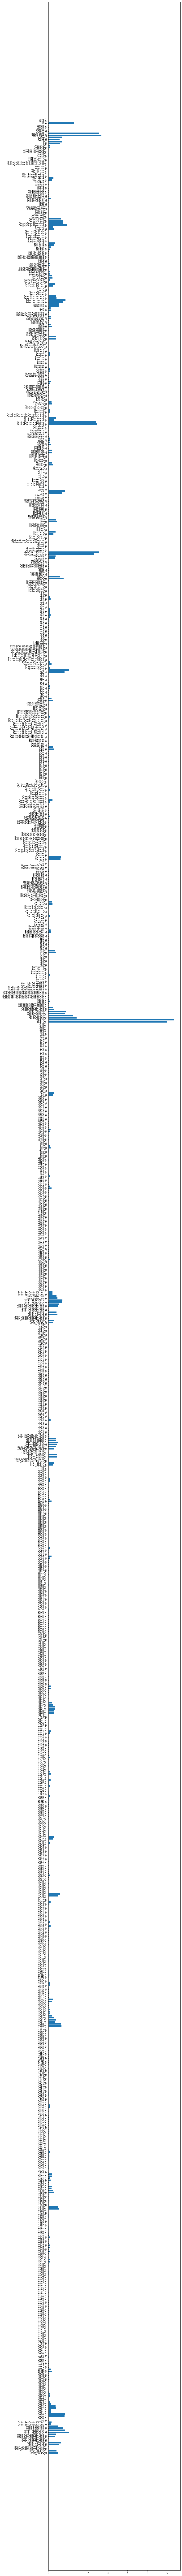

In [0]:
plt.subplots(figsize=(10,200))
plt.barh(train_X.keys(), model.get_feature_importance())

In [0]:
train_X.keys()[model.get_feature_importance() == 0]

Index(['1026_1', '1028_0', '1028_1', '1028_div_event_0', '1028_div_event_1',
       '1028_per_sec_0', '1028_per_sec_1', '1029_0', '1029_1',
       '1029_div_event_0',
       ...
       'ZerglingBurrowed_1', 'ZerglingBurrowed_div_event_0',
       'ZerglingBurrowed_div_event_1', 'ZerglingBurrowed_per_sec_0',
       'ZerglingBurrowed_per_sec_1', 'protoss_0', 'protoss_1', 'terran_0',
       'zerg_0', 'zerg_1'],
      dtype='object', length=1614)

In [0]:
X_selected = X.drop(train_X.keys()[model.get_feature_importance() == 0], axis=1)

In [0]:
train_X, valid_X, train_y, valid_y = train_test_split(X_selected, y, test_size=0.33, random_state=random_seed)

In [0]:
model = CatBoostClassifier(iterations=25000,              # 반복횟수 최대 25000
                           learning_rate=0.001,           # 러닝레이트 0.001
                           depth=10,                       # 트리 깊이 ~16, 디폴트 6
                           l2_leaf_reg=30,                # L2 정규화
                           random_seed=random_seed,       # 랜덤시드 고정
                           eval_metric='AUC',             # AUC로 성능 측정
                           metric_period=2500,            # 중간결과 출력
                           early_stopping_rounds=1000,    # 1000iteration 동안 AUC 증가 없으면 학습 중단
                           grow_policy='Lossguide',   # 트리 생성 방식, SymmetricTree는 wide, 깊이 일정, Lossguide는 deep
                           task_type='GPU'                # GPU 사용
                           )
model.fit(train_X, train_y, eval_set=(valid_X, valid_y))
#test_pred = model.predict_proba(test_X)

0:	learn: 0.6492826	test: 0.6385804	best: 0.6385804 (0)	total: 94ms	remaining: 39m 11s
2500:	learn: 0.7388755	test: 0.7105573	best: 0.7105573 (2500)	total: 2m 23s	remaining: 21m 31s
5000:	learn: 0.7649169	test: 0.7243085	best: 0.7243085 (5000)	total: 4m 37s	remaining: 18m 30s
7500:	learn: 0.7831038	test: 0.7316101	best: 0.7316101 (7500)	total: 6m 49s	remaining: 15m 56s
10000:	learn: 0.7978168	test: 0.7361645	best: 0.7361645 (10000)	total: 8m 54s	remaining: 13m 22s
12500:	learn: 0.8104428	test: 0.7394039	best: 0.7394045 (12499)	total: 11m	remaining: 11m
15000:	learn: 0.8216650	test: 0.7418183	best: 0.7418183 (15000)	total: 13m 7s	remaining: 8m 45s
17500:	learn: 0.8318494	test: 0.7436680	best: 0.7436680 (17500)	total: 15m 12s	remaining: 6m 30s
20000:	learn: 0.8411330	test: 0.7451423	best: 0.7451433 (19999)	total: 17m 17s	remaining: 4m 19s
22500:	learn: 0.8497205	test: 0.7463787	best: 0.7463787 (22500)	total: 19m 22s	remaining: 2m 9s
24999:	learn: 0.8577067	test: 0.7473281	best: 0.7473282

lightgbm

In [0]:
  model = LGBMClassifier()
  model.set_params(boosting_type='gbdt',
                   bagging_freq=10,
                   bagging_seed=2020,
                   bagging_fraction=0.7,
                   feature_fraction=0.7,
                   num_leaves=100, 
                   max_depth=-1, 
                   learning_rate=0.01, 
                   n_estimators=2500,
                   random_state=2020, 
                   n_jobs=-1,
                   importance_type='split',
                   is_training_metric=True,
                   eval_metric='logloss',
                   early_stopping_rounds=10,
                   )
  
  start = time.time()
  model.fit(train_X, train_y, eval_set=(valid_X, valid_y))
  print("time :", time.time() - start)

  #test_pred = model.predict_proba(test_x)

[1]	valid_0's binary_logloss: 0.692481
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.691729
[3]	valid_0's binary_logloss: 0.691042
[4]	valid_0's binary_logloss: 0.690313
[5]	valid_0's binary_logloss: 0.689642
[6]	valid_0's binary_logloss: 0.688873
[7]	valid_0's binary_logloss: 0.688254
[8]	valid_0's binary_logloss: 0.68779
[9]	valid_0's binary_logloss: 0.687134
[10]	valid_0's binary_logloss: 0.686511
[11]	valid_0's binary_logloss: 0.685906
[12]	valid_0's binary_logloss: 0.685307
[13]	valid_0's binary_logloss: 0.684792
[14]	valid_0's binary_logloss: 0.684276
[15]	valid_0's binary_logloss: 0.683541
[16]	valid_0's binary_logloss: 0.682825
[17]	valid_0's binary_logloss: 0.682354
[18]	valid_0's binary_logloss: 0.681801
[19]	valid_0's binary_logloss: 0.681222
[20]	valid_0's binary_logloss: 0.680662
[21]	valid_0's binary_logloss: 0.680001
[22]	valid_0's binary_logloss: 0.679463
[23]	valid_0's binary_logloss: 0.679016
[24]	valid_0's binary_loglos

### <b>모델 생성, 적용

### <b>모델 앙상블

### <b>제출 파일 생성

In [0]:
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)
submission = pd.DataFrame(data=test_pred[:,1], columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('cat_depth6_1.csv', index=True)